In [230]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

pd.set_option('display.max_columns', 1000, 'display.max_colwidth', 1000, 'display.max_rows',1000)
import warnings
warnings.filterwarnings('ignore')

# Stocks

In [251]:
def convert_date(x,h, m):
    x = str.split(x,sep='-')
    x = [int(item) for item in x]
    date = datetime(year=x[0],month=x[1],day=x[2],hour=h, minute=m, second=0)
    return date

def stockDirection(x, pct=10):
     # increase is 2, decrease is 0, remaining constant (+-pct%) is 1
    if x<=-pct:
        return 0
    elif x>=pct:
        return 2
    else:
        return 1

def read_stocks_data_header(filename,read_lines=3):
    # Stocks Data is in UTC

    #generate header from the file
    with open(filename) as myfile:
        head1 =[]
        for i in range (0,read_lines):
            head1.append([str.split(next(myfile).strip(),sep=',') for x in range(0,1)])

    line1 = head1[0][0]
    line2 = head1[1][0]
    line3 = head1[2][0]

    header = [j.replace('^','')+' '+i+k for i, j,k in zip(line1, line2, line3)]
    header = [item.replace(' ','') for item in header]

    return header

def stock_direction(df):
    cols = list(df.columns)
    cols = [i for i in cols if 'Date' not in i]
    print(cols)
    for col in cols:
        x = col
        col_r = col.replace('Open','Delta')
        col_r = col.replace('Close','Delta')
        df[col_r] = df[col].dropna().diff()

        col_rr = x.replace('Open','Direction')
        col_rr = x.replace('Close','Direction')
        df[col_rr] = df[col_r].dropna().apply(lambda row: stockDirection(row, 0))
    return df

def read_stocks_data(filename,header,skiprows):
    df = pd.read_csv(filename,names=header,skiprows=3)
    df['Date']=pd.to_datetime(df.Datetime)

    colofinterest= ['Date','CL=FOpen','CL=FAdjClose', 'GSPCOpen','GSPCAdjClose', 'GSPTSEOpen', 'GSPTSEAdjClose', 'IXICOpen', 'IXICAdjClose']
    df=df[colofinterest]
    df.drop_duplicates(subset='Date', inplace=True)

    
    open_col = ([col for col in df_stocks.columns if 'Open' in col])
    open_col.append('Date')
    df_open = df[open_col]

    close_col = [col for col in df_stocks.columns if 'Close' in col]
    close_col.append('Date')
    df_close = df[close_col]

    df_open_1 = stock_direction(df_open)
    df_close_1 = stock_direction(df_close)
    return df_open_1, df_close_1

In [254]:
# Stocks Data
filename='data/ ^GSPC CL=F ^IXIC ^GSPTSE_5m.csv'
header = read_stocks_data_header(filename)
df_stocks_open, df_stocks_close = read_stocks_data(filename,header,3)

['CL=FOpen', 'GSPCOpen', 'GSPTSEOpen', 'IXICOpen']
['CL=FAdjClose', 'GSPCAdjClose', 'GSPTSEAdjClose', 'IXICAdjClose']


# Generate a list of dates

In [255]:
# Date Range
df_date= pd.DataFrame()
df_date['Date'] = pd.bdate_range(start='2022-01-01', end='2022-03-26', freq='min')
df_date

,Date
0,2022-01-01 00:00:00
1,2022-01-01 00:01:00
2,2022-01-01 00:02:00
3,2022-01-01 00:03:00
4,2022-01-01 00:04:00
...,...
120956,2022-03-25 23:56:00
120957,2022-03-25 23:57:00
120958,2022-03-25 23:58:00
120959,2022-03-25 23:59:00


# Tweet Cleaning

In [13]:
# To clean up texts
import re
import nltk
# nltk.download() Download nltk data for first time use (download all packages)
import nltk.data
# from nltk.stem.snowball import SnowballStemmer
# stemmer = SnowballStemmer('english')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords

# tokenizer = nltk.data.load('nltk:tokenizers/punkt/english.pickle')
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('omw-1.4')


In [14]:
# Tweets Data
df_tweets = pd.read_csv('data/combined_data.csv').iloc[:,1:]
df_tweets['Date'] = df_tweets.Time.apply(pd.to_datetime)
df_tweets = df_tweets.dropna(how='any')
df_tweets.drop(columns='Time', inplace =True)
df_tweets.rename(columns={'Date':'tweet_date'}, inplace = True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17327 entries, 0 to 17346
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Content     17327 non-null  object        
 1   tweet_date  17327 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 406.1+ KB


In [15]:
# Get US holidays
from pandas.tseries.holiday import USFederalHolidayCalendar
cal = USFederalHolidayCalendar()
holidays = cal.holidays(start='2016-01-01', end='2022-12-31').to_pydatetime()
holiday_date = []
for days in holidays:
    holiday_date.append(days.date())

#check weekend or US holiday
def IsHoliday(x,holiday_date):
    # date = x.date()
    weekday = x.weekday()
    if (x in holiday_date) | (weekday==5) | (weekday==6):
        return True #it is holiday
    else:
        return False #it is not holiday

#during market or after market
def IsAfterMkt(x):
    x = x.time()
    starttime = datetime.strptime('9:30:00','%H:%M:%S').time()
    endtime = datetime.strptime('16:00:00','%H:%M:%S').time()
    if ((x >= starttime) & (x<=endtime)):
         return False
    else:
        return True

# Same day or next day
def IsSameDay(x):
    x = x.time()
    samedaystarttime = datetime.strptime('00:00:00','%H:%M:%S').time()
    samedayndtime = datetime.strptime('9:30:00','%H:%M:%S').time()
    if ((x >= samedaystarttime) & (x < samedayndtime)):
        return True
    else:
        return False


# transform date to correspond to stock market open or close   
def edit_date(x):
    # x = x-timedelta(hours=5)
    date = x.date()
    time = x.time()
    while IsHoliday(date,holiday_date)==1:
        date=date+timedelta(days=1)
    
    if IsAfterMkt(x)==True:
        time=datetime.strptime('9:30:00','%H:%M:%S').time()
        if IsSameDay(x)==False:
            date=date+timedelta(days=1)
    else:
        time=datetime.strptime('16:00:00','%H:%M:%S').time()

    date_time = str(date)+ ' '+ str(time)
    date_time = datetime.strptime(date_time, "%Y-%m-%d %H:%M:%S")
    return date_time

df_tweets['tweet_day'] = df_tweets.tweet_date.apply(lambda row:row.weekday())
df_tweets['Date'] = df_tweets.tweet_date.apply(lambda row:edit_date(row))
df_tweets['Day'] = df_tweets.Date.apply(lambda row:row.weekday())
# df_tweets['Date'].apply(lambda row:row+timedelta(hours=5))

df_tweets.head()

,Content,tweet_date,tweet_day,Date,Day
0,"@haltman Little do they know, birds aren't rea...",2022-03-11 14:41:00,4,2022-03-11 16:00:00,4
1,@waitbutwhy What if one atom at a time in your...,2022-03-10 19:31:00,3,2022-03-11 09:30:00,4
2,@WholeMarsBlog @Erdayastronaut @CopSub This we...,2022-03-10 00:44:00,3,2022-03-10 09:30:00,3
3,@FedorovMykhailo @OMarkarova You're welcome. W...,2022-03-09 16:49:00,2,2022-03-10 09:30:00,3
4,"@PPathole @SpaceX Optimized, fully-reusable St...",2022-03-09 16:41:00,2,2022-03-10 09:30:00,3


In [16]:
stop_words = set(stopwords.words('english'))

def sentence_to_wordlist(sentence, remove_stopwords=False):
    # 0. remove mentions(@), Hashtag(#)
    sentence = re.sub(r'@[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'#[^\s]+', '', sentence,flags=re.MULTILINE )
    sentence = re.sub(r'RT[^\s]+', '', sentence,flags=re.MULTILINE )
    # 1. drop http
    p1=re.compile(r'http?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 2. drop https
    p1=re.compile(r'https?:\/\/\S+', flags=re.DOTALL)
    sentence = re.sub(p1, '', sentence)
    # 3. Remove non-letters
    sentence = re.sub(r'[^\w\s]','', sentence)
    # 4. Remove all numbers
    sentence = re.sub(r'[0-9]+', '', sentence)
    # 5. Convert words to lower case and split them
    sentence = sentence.lower().split()
    # Remove Stop Words
    # sentence = [word for word in sentence if not word in stop_words]
    # 5. Stemming
    # sentence = [stemmer.stem(w) for w in sentence] 
    # 6. Lemmatizing
    sentence = [lemmatizer.lemmatize(word) for word in sentence]

    #check if returned sentence is blank
    if len(sentence)==0:
      return np.nan
    else:
      # 7. Return a sentence of words
      sentence_r = ''
      for word in sentence:
        sentence_r = sentence_r + ' ' + word
      return(sentence_r)

# def cleanText(text):
#   text = re.sub('@[A-Za-z0-9]+' , '', text) #remove the @mentions
#   text = re.sub('https?:\/\/\S+' , '', text) #remove the hyperlinks
#   text = re.sub(r'#', '', text) #removing #tags
#   text = re.sub(r'RT[\s]+', '', text) #removing RT(ReTweets)
#   return text

In [17]:
# create a new column 
df_tweets['Content1']= df_tweets.Content.apply(lambda row: sentence_to_wordlist(row))
df_tweets.dropna(how='any', inplace=True)
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16151 entries, 0 to 17346
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Content     16151 non-null  object        
 1   tweet_date  16151 non-null  datetime64[ns]
 2   tweet_day   16151 non-null  int64         
 3   Date        16151 non-null  datetime64[ns]
 4   Day         16151 non-null  int64         
 5   Content1    16151 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 883.3+ KB


# Tweet Sentiments

In [18]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon', quiet=True)

def polarityScore(a, col):
    # Create a column for score
    a['score'] = a[col].apply(lambda row: calculate_polarity_scores(row))
    #split all the scores into separate columns
    # columns = ['negative', 'neutral', 'positive', 'compound'])
    a['negative']=a.score.apply(lambda x: x[0])
    a['neutral']=a.score.apply(lambda x: x[1])
    a['positive']=a.score.apply(lambda x: x[2])
    a['combined']=a.score.apply(lambda x: x[3])
    return a

def calculate_polarity_scores(x):
    sid = SentimentIntensityAnalyzer()
    score = sid.polarity_scores(x)
    score_list = []
    for i in score.values():
        score_list.append(i)
    return score_list

In [19]:
df_tweets = polarityScore(df_tweets, 'Content1')
# sns.histplot(data=result, x='compound')
df_tweets.head()

,Content,tweet_date,tweet_day,Date,Day,Content1,score,negative,neutral,positive,combined
0,"@haltman Little do they know, birds aren't rea...",2022-03-11 14:41:00,4,2022-03-11 16:00:00,4,little do they know bird arent real,"[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000
1,@waitbutwhy What if one atom at a time in your...,2022-03-10 19:31:00,3,2022-03-11 09:30:00,4,what if one atom at a time in your body wa sw...,"[0.0, 0.933, 0.067, 0.3182]",0.0,0.933,0.067,0.3182
2,@WholeMarsBlog @Erdayastronaut @CopSub This we...,2022-03-10 00:44:00,3,2022-03-10 09:30:00,3,this weekend,"[0.0, 1.0, 0.0, 0.0]",0.0,1.000,0.000,0.0000
3,@FedorovMykhailo @OMarkarova You're welcome. W...,2022-03-09 16:49:00,2,2022-03-10 09:30:00,3,youre welcome we have also sent power adapter...,"[0.0, 0.88, 0.12, 0.4588]",0.0,0.880,0.120,0.4588
4,"@PPathole @SpaceX Optimized, fully-reusable St...",2022-03-09 16:41:00,2,2022-03-10 09:30:00,3,optimized fullyreusable starship is t to same...,"[0.0, 0.842, 0.158, 0.4588]",0.0,0.842,0.158,0.4588


<AxesSubplot:xlabel='combined', ylabel='Count'>

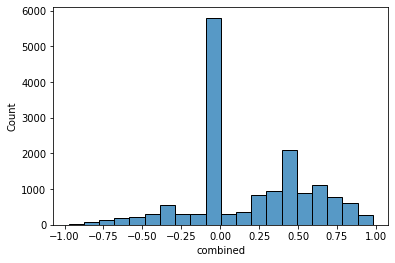

In [42]:
import seaborn as sns
sns.histplot(data=df_tweets, x='combined',bins=20)

# Merge

<AxesSubplot:xlabel='inc/dec', ylabel='Count'>

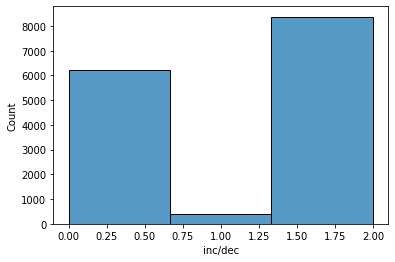

In [59]:
df = pd.merge(df_date,df_stocks,how='left', on='Date')
df = pd.merge(df, df_tweets, how='left', on='Date')
df = df.dropna().reset_index(drop=True)
sns.histplot(data=df, x='inc/dec',bins=3)

# Last Step 

In [60]:
df.groupby(['inc/dec'])[['combined','negative','neutral','positive']].mean()

,combined,negative,neutral,positive
inc/dec,,,,
0.0,0.194630,0.050067,0.721045,0.227124
1.0,0.205909,0.049311,0.720704,0.229990
2.0,0.194680,0.051814,0.716058,0.229261


In [61]:
df.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']]\
    .mean().reset_index(drop=True)\
    .to_csv('data/finaldata.csv',index=False, header=True)

In [62]:
df.groupby(['Date'])[['combined','negative','neutral','positive','inc/dec']].mean().reset_index(drop=True)

,combined,negative,neutral,positive,inc/dec
0,0.000000,0.000000,1.000000,0.00000,2.0
1,-0.031450,0.121500,0.841500,0.03700,0.0
2,0.231475,0.000000,0.901250,0.09875,0.0
3,0.000000,0.000000,1.000000,0.00000,0.0
4,0.201050,0.000000,0.672250,0.32775,2.0
...,...,...,...,...,...
1732,0.268850,0.068667,0.645667,0.28550,0.0
1733,-0.011789,0.059111,0.836889,0.10400,0.0
1734,0.167250,0.055500,0.835750,0.10875,2.0
1735,-0.299700,0.140500,0.859500,0.00000,0.0


In [ ]:
df[['Date','Content','Content1','combined','negative','neutral','positive','inc/dec']].to_csv('data/results.csv',index=False, sep=',')